In [612]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [558]:
train = pd.read_csv('Train.csv')
train.head()

,dev_coding_hours,caffeine_intake_mg,distractions,sleep_duration_hours,code_commits,issues_reported,mental_effort_score,task_completion_status,ai_tool_usage_hours
0,3.882167,598,4,5.778520,1,0,5.357277,0,1.1884
1,3.444245,619,3,5.214190,8,0,6.379272,0,1.4412
2,0.961280,542,1,5.141088,7,0,2.658780,0,0.7293
3,2.428623,296,2,5.027432,2,0,4.726051,1,0.8373
4,3.463530,223,1,5.180457,5,2,4.719144,0,0.9635


In [559]:
train.shape

(25000, 9)

In [560]:
train.isnull().sum()

dev_coding_hours             0
caffeine_intake_mg           0
distractions                 0
sleep_duration_hours         0
code_commits                 0
issues_reported              0
mental_effort_score          0
task_completion_status       0
ai_tool_usage_hours       6653
dtype: int64

In [561]:
train.duplicated().sum()

0

In [562]:
test = pd.read_csv('Test.csv')
test.head()

,dev_coding_hours,caffeine_intake_mg,distractions,sleep_duration_hours,code_commits,issues_reported,mental_effort_score,task_completion_status,ai_tool_usage_hours
0,0.109040,595,1,5.424848,6,2,7.416031,1,NaN
1,4.959875,580,1,7.377921,1,0,5.137299,1,NaN
2,4.909689,136,1,6.576004,6,1,3.227282,0,NaN
3,2.820942,324,2,8.459569,4,1,3.574895,0,NaN
4,5.531184,316,1,5.372195,5,0,6.123869,1,NaN


In [563]:
test.shape

(200, 9)

In [564]:
test.isnull().sum()

dev_coding_hours            0
caffeine_intake_mg          0
distractions                0
sleep_duration_hours        0
code_commits                0
issues_reported             0
mental_effort_score         0
task_completion_status      0
ai_tool_usage_hours       200
dtype: int64

In [565]:
test.duplicated().sum()

0

In [566]:
combined = pd.concat([train, test], axis = 0)
combined.shape

(25200, 9)

In [567]:
epsilon = 1e-3

In [568]:
combined['commits_per_hour'] = combined['code_commits'] / (combined['dev_coding_hours'] + epsilon)

In [569]:
combined['issue_commit_ratio'] = combined['issues_reported'] / (combined['code_commits'] + 1)

In [570]:
combined['focus_score'] = combined['dev_coding_hours'] / (combined['distractions'] + 1)

In [571]:
combined['caffeine_sleep_ratio'] = combined['caffeine_intake_mg'] / (combined['sleep_duration_hours'] + epsilon)

In [572]:
combined['efficiency_score'] = combined['task_completion_status'] / (combined['mental_effort_score'] + 1)

In [573]:
combined['energy_index'] = combined['sleep_duration_hours'] * combined['dev_coding_hours']

In [574]:
combined['adjusted_effort'] = (combined['mental_effort_score'] * (combined['distractions'] + 1)) / (combined['sleep_duration_hours'] + 1)

In [575]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dev_coding_hours        25200 non-null  float64
 1   caffeine_intake_mg      25200 non-null  int64  
 2   distractions            25200 non-null  int64  
 3   sleep_duration_hours    25200 non-null  float64
 4   code_commits            25200 non-null  int64  
 5   issues_reported         25200 non-null  int64  
 6   mental_effort_score     25200 non-null  float64
 7   task_completion_status  25200 non-null  int64  
 8   ai_tool_usage_hours     18347 non-null  float64
 9   commits_per_hour        25200 non-null  float64
 10  issue_commit_ratio      25164 non-null  float64
 11  focus_score             25200 non-null  float64
 12  caffeine_sleep_ratio    25200 non-null  float64
 13  efficiency_score        25200 non-null  float64
 14  energy_index            25200 non-null  float

In [576]:
input_variables = combined[['dev_coding_hours', 'caffeine_intake_mg', 'distractions', 'sleep_duration_hours', 'code_commits','issues_reported',
    'mental_effort_score', 'task_completion_status']]

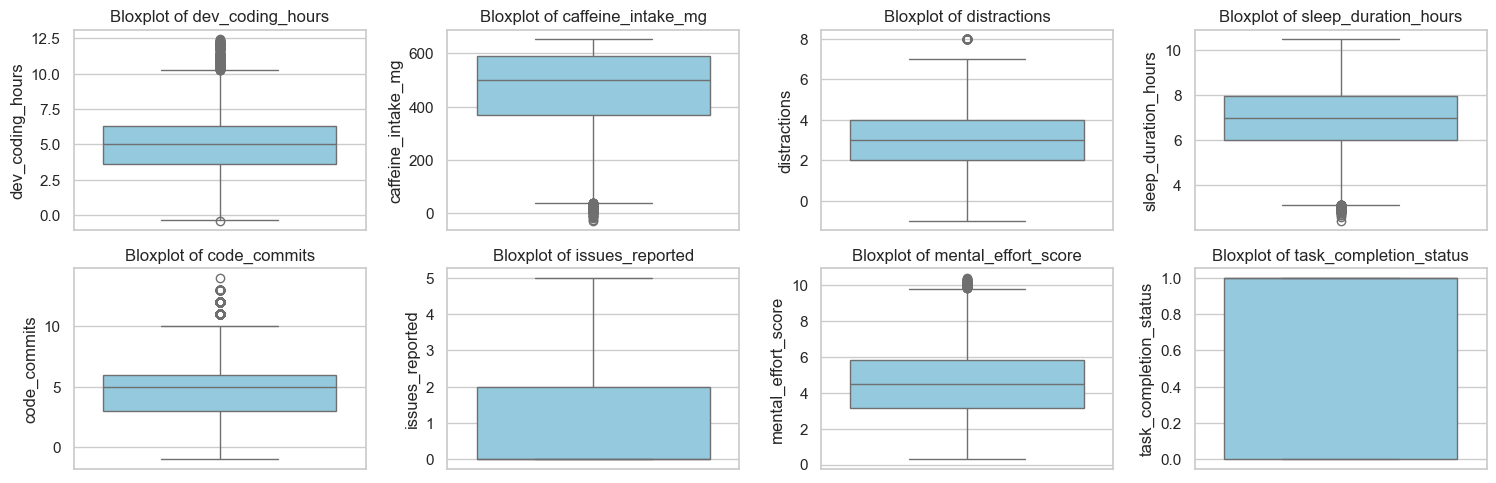

In [577]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(input_variables.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Bloxplot of {col}')

plt.tight_layout()
plt.show()

In [578]:
def replace_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    median_value = df[column].median()
    df[column] = np.where((df[column]<lower)|(df[column]>upper), median_value, df[column])
    return df

In [579]:
for col in input_variables.columns:
    concat_df = replace_outliers(combined, col)

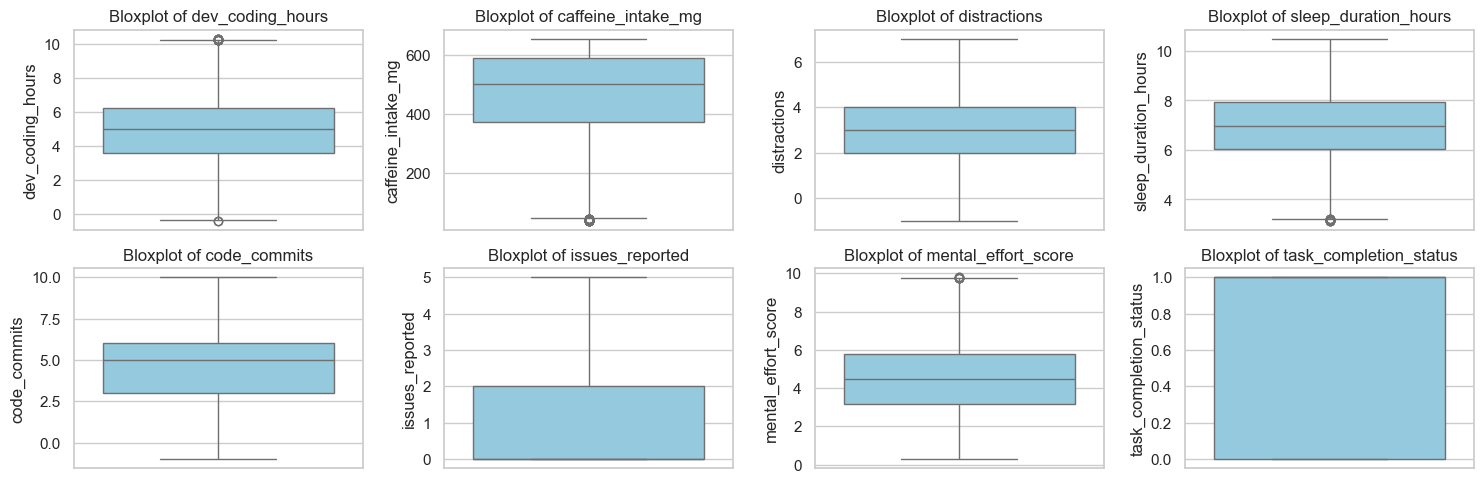

In [580]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(input_variables.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Bloxplot of {col}')

plt.tight_layout()
plt.show()

In [581]:
combined['issue_commit_ratio'] = combined['issue_commit_ratio'].fillna(0.00)

In [582]:
combined.head()

,dev_coding_hours,caffeine_intake_mg,distractions,sleep_duration_hours,code_commits,issues_reported,mental_effort_score,task_completion_status,ai_tool_usage_hours,commits_per_hour,issue_commit_ratio,focus_score,caffeine_sleep_ratio,efficiency_score,energy_index,adjusted_effort
0,3.882167,598.0,4.0,5.778520,1.0,0.0,5.357277,0.0,1.1884,0.257522,0.000000,0.776433,103.468805,0.00000,22.433176,3.951657
1,3.444245,619.0,3.0,5.214190,8.0,0.0,6.379272,0.0,1.4412,2.322041,0.000000,0.861061,118.691739,0.00000,17.958947,4.106261
2,0.961280,542.0,1.0,5.141088,7.0,0.0,2.658780,0.0,0.7293,7.274389,0.000000,0.480640,105.404646,0.00000,4.942026,0.865899
3,2.428623,296.0,2.0,5.027432,2.0,0.0,4.726051,1.0,0.8373,0.823173,0.000000,0.809541,58.865270,0.17464,12.209735,2.352271
4,3.463530,223.0,1.0,5.180457,5.0,2.0,4.719144,0.0,0.9635,1.443197,0.333333,1.731765,43.038088,0.00000,17.942668,1.527118


In [583]:
x = ['code_commits', 'issues_reported', 'task_completion_status', 'distractions']
for i in x:
    combined[i] = combined[i].astype(int)

In [584]:
float_cols = combined.select_dtypes(include='float').columns
combined[float_cols] = combined[float_cols].round(2)

In [585]:
combined.shape

(25200, 16)

In [586]:
combined.replace([np.inf, -np.inf], np.nan, inplace=True)
combined.fillna(combined.median(), inplace=True)

In [587]:
newtrain = combined.iloc[0:18346, :]
newtest = combined.iloc[25000:, : ]
newtest = newtest.drop('ai_tool_usage_hours', axis = 1)

In [588]:
newtrain.shape

(18346, 16)

In [589]:
newtest.shape

(200, 15)

In [590]:
x = newtrain.drop('ai_tool_usage_hours', axis = 1)
y = newtrain['ai_tool_usage_hours']

In [591]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [592]:
models = {'Linear Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(), 'CatBoost': CatBoostRegressor()}

In [593]:
def evaluate_models(x_train, x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        cv_rmse = cross_val_score(model, x_train, y_train, scoring='r2', cv=5).mean()
        results[name] = cv_rmse
    return results  

In [594]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2419
[LightGBM] [Info] Number of data points in the train set: 11740, number of used features: 15
[LightGBM] [Info] Start training from score 1.624990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2422
[LightGBM] [Info] Number of data points in the train set: 11741, number of used features: 15
[LightGBM] [Info] Start training from score 1.615562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2419
[LightGBM] [Info] Number of data points in the train set: 11741, number of used features: 15
[LightGBM] [Info] Start tra

In [595]:
best_model_name = max(results, key = results.get)
best_model = models[best_model_name]

In [596]:
print(f"best model is {best_model_name} with r2 {results[best_model_name]}")

best model is Linear Regression with r2 -0.0012146338141818536


In [597]:
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [598]:
print(r2_score(y_test, y_pred))

-0.0015130580673985428


In [599]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, x.columns), reverse=True)[:20], columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title(f'{best_model_name} Features')
plt.tight_layout()
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [600]:
x_train = newtrain.drop('ai_tool_usage_hours', axis = 1)
y_train = newtrain['ai_tool_usage_hours']
x_test = newtest
y_pred = best_model.fit(x_train, y_train).predict(x_test)
solution = pd.DataFrame({'ai_tool_usage_hours': y_pred})
solution.head()

,ai_tool_usage_hours
0,1.575897
1,1.641470
2,1.630665
3,1.629965
4,1.630835


In [602]:
solution.to_csv('Solution.csv', index = False)

In [610]:
rf = Ridge()
x_train = newtrain.drop('ai_tool_usage_hours', axis = 1)
y_train = newtrain['ai_tool_usage_hours']
x_test = newtest
y_pred = rf.fit(x_train, y_train).predict(x_test)
solution = pd.DataFrame({'ai_tool_usage_hours': y_pred})
solution.to_csv('Ridge.csv', index = False)